In [126]:
import tensorflow as tf
from tensorflow import keras
print("GPUs:",len(tf.config.experimental.list_physical_devices('GPU')))
tf.test.is_built_with_cuda()

GPUs: 1


True

In [127]:
print(tf.version.VERSION)
import sys
sys.version

2.10.1


'3.10.16 | packaged by Anaconda, Inc. | (main, Dec 11 2024, 16:19:12) [MSC v.1929 64 bit (AMD64)]'

In [128]:
import os
import shutil
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow 
import keras
from collections import deque
import matplotlib.pyplot as plt
#plt.style.use("seaborn")

%matplotlib inline
 
from sklearn.model_selection import train_test_split
 
from keras.layers import *
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

### Preprocess the Dataset

In [129]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64
 
# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20
 
dataset_dir = os.path.expanduser("D:/21102A0004/data")
 
CLASSES_LIST = ["crime","non-crime"]

# Verify if the dataset directory exists
if not os.path.exists(dataset_dir):
    print(f"Dataset directory does not exist: {dataset_dir}")
else:
    print(f"Dataset directory exists: {dataset_dir}")

Dataset directory exists: D:/21102A0004/data


### Create a Function to Extract, Resize & Normalize Frames

In [130]:
def frames_extraction(video_path):
 
    frames_list = []
    
    # Read the Video File
    video_reader = cv2.VideoCapture(video_path)
 
    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
 
    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)
 
    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):
 
        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
 
        # Reading the frame from the video. 
        success, frame = video_reader.read() 
 
        if not success:
            break
 
        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame
        normalized_frame = resized_frame / 255
        
        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
 
    video_reader.release()
 
    return frames_list

In [131]:
def create_dataset():
 
    features = []
    labels = []
    video_files_paths = []
    
    # Iterating through all the classes.
    for class_index, class_name in enumerate(CLASSES_LIST):
        
        print(f'Extracting Data of Class: {class_name}')
        
        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(dataset_dir, class_name))
        
        # Iterate through all the files present in the files list.
        for file_name in files_list:
            
            # Get the complete video path.
            video_file_path = os.path.join(dataset_dir, class_name, file_name)
 
            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)
 
            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:
 
                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)
 
    features = np.asarray(features)
    labels = np.array(labels)  

    return features, labels, video_files_paths

In [132]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: crime
Extracting Data of Class: non-crime


In [133]:
# Saving the extracted data
np.save("features1.npy",features)
np.save("labels1.npy",labels)
np.save("video_files_paths1.npy",video_files_paths)

In [134]:
features, labels, video_files_paths = np.load("features1.npy") , np.load("labels1.npy") ,  np.load("video_files_paths1.npy")

In [135]:
# convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

### Split the Data into Train and Test Set

In [136]:
# Split the Data into Train ( 80% ) and Test Set ( 20% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.2,
                                                                            shuffle = True, random_state = 42)

In [137]:
print(features_train.shape,labels_train.shape )
print(features_test.shape, labels_test.shape)

(2031, 20, 64, 64, 3) (2031, 2)
(508, 20, 64, 64, 3) (508, 2)


## LRCN Model

###  Construct the Model

In [138]:
def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = Sequential()
    
    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(32))
                                      
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    ########################################################################################################################

    # Display the models summary.
    model.summary()
    
    # Return the constructed LRCN model.
    return model

In [139]:
# Construct the required LRCN model.
LRCN_model = create_LRCN_model()

# Display the success message.
print("Model Created Successfully!")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_12 (TimeDi  (None, 20, 64, 64, 16)   448       
 stributed)                                                      
                                                                 
 time_distributed_13 (TimeDi  (None, 20, 16, 16, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 20, 16, 16, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 20, 16, 16, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_16 (TimeDi  (None, 20, 4, 4, 32)    

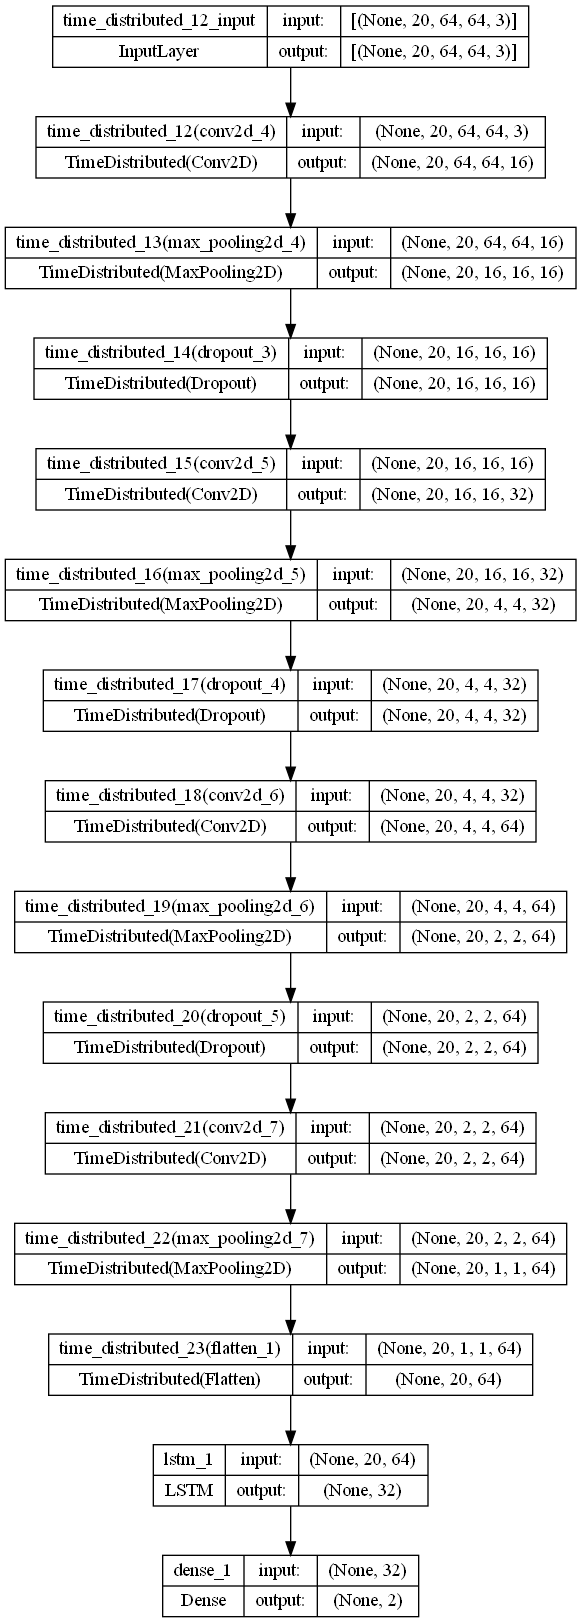

In [140]:
# Plot the structure of the contructed LRCN model.
plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [141]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
 
# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 70, batch_size = 4 ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/70
406/406 [==============================] - 42s 100ms/step - loss: 0.6892 - accuracy: 0.5142 - val_loss: 0.6587 - val_accuracy: 0.5921
Epoch 2/70
406/406 [==============================] - 3s 7ms/step - loss: 0.6249 - accuracy: 0.6361 - val_loss: 0.6578 - val_accuracy: 0.5676
Epoch 3/70
406/406 [==============================] - 3s 7ms/step - loss: 0.5932 - accuracy: 0.6853 - val_loss: 0.6238 - val_accuracy: 0.6167
Epoch 4/70
406/406 [==============================] - 3s 7ms/step - loss: 0.5483 - accuracy: 0.7211 - val_loss: 0.5616 - val_accuracy: 0.7297
Epoch 5/70
406/406 [==============================] - 2s 6ms/step - loss: 0.5038 - accuracy: 0.7512 - val_loss: 0.5194 - val_accuracy: 0.7445
Epoch 6/70
406/406 [==============================] - 3s 6ms/step - loss: 0.4624 - accuracy: 0.7814 - val_loss: 0.5065 - val_accuracy: 0.7568
Epoch 7/70
406/406 [==============================] - 3s 6ms/step - loss: 0.4118 - accuracy: 0.8103 - val_loss: 0.4865 - val_accuracy: 0.7617
Epo

In [142]:
# Evaluate the trained model.
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

16/16 [==============================] - 0s 22ms/step - loss: 0.3562 - accuracy: 0.8504


In [143]:
LRCN_model.save("lrcn_model.h5")

In [144]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    plt.clf()
    
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Get the Epochs Count
    epochs = range(len(metric_value_1))
 
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'orange', label = metric_name_2)
 
    plt.title(str(plot_name))
 
    plt.legend()
    plt.show()

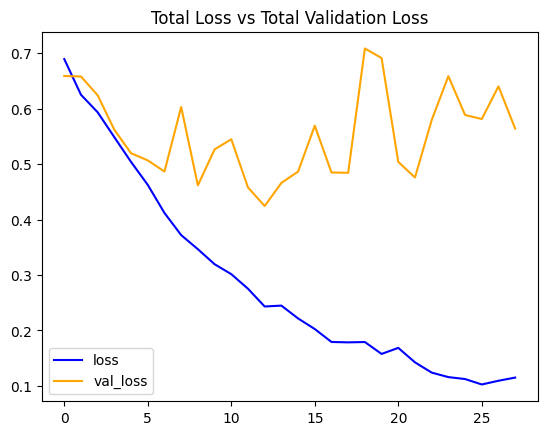

In [145]:
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

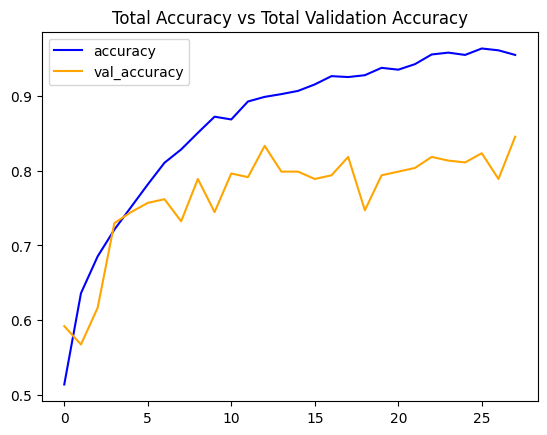

In [146]:
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [147]:
labels_predict = LRCN_model.predict(features_test)

16/16 [==============================] - 0s 8ms/step


In [148]:
# Decoding the data to use in Metrics
labels_predict = np.argmax(labels_predict , axis=1)
labels_test_normal = np.argmax(labels_test , axis=1)

In [149]:
labels_test_normal.shape , labels_predict.shape

((508,), (508,))

In [150]:
from sklearn.metrics import accuracy_score
AccScore = accuracy_score(labels_predict, labels_test_normal)
print('Accuracy Score is : ', AccScore)

Accuracy Score is :  0.8503937007874016


In [151]:
# import seaborn as sns 
# from sklearn.metrics import confusion_matrix

# ax= plt.subplot()
# cm=confusion_matrix(labels_test_normal, labels_predict)
# sns.heatmap(cm, annot=True, fmt='g', ax=ax);  

# ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
# ax.set_title('Confusion Matrix'); 
# ax.xaxis.set_ticklabels(['True', 'False']); ax.yaxis.set_ticklabels(['crime', 'non-crime']);

In [152]:
plt.clf()

<Figure size 640x480 with 0 Axes>

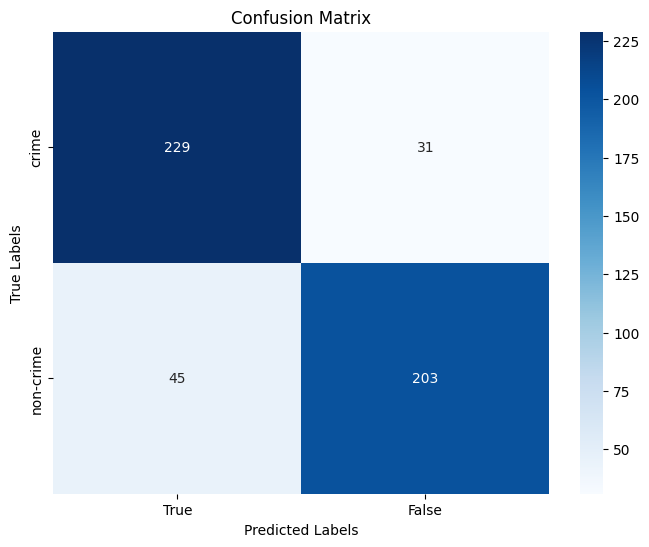

In [153]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Ensure inline plotting
%matplotlib inline

# Create confusion matrix
cm = confusion_matrix(labels_test_normal, labels_predict)

# Create the plot
plt.figure(figsize=(8, 6))  # Set the figure size
ax = sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')

# Set labels and title
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')

# Set custom tick labels (modify as per your data)
ax.xaxis.set_ticklabels(['True', 'False'])
ax.yaxis.set_ticklabels(['crime', 'non-crime'])

# Show the plot
plt.show()


In [154]:
from sklearn.metrics import classification_report

ClassificationReport = classification_report(labels_test_normal,labels_predict)
print('Classification Report is : \n', ClassificationReport)

Classification Report is : 
               precision    recall  f1-score   support

           0       0.84      0.88      0.86       260
           1       0.87      0.82      0.84       248

    accuracy                           0.85       508
   macro avg       0.85      0.85      0.85       508
weighted avg       0.85      0.85      0.85       508



### Prediction

In [155]:
def predict_video(video_file_path, SEQUENCE_LENGTH):
 
    video_reader = cv2.VideoCapture(video_file_path)
 
    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
 
    # Declare a list to store video frames we will extract.
    frames_list = []
    
    # Store the predicted class in the video.
    predicted_class_name = ''
 
    # Get the number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
 
    # Calculate the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH),1)
 
    # Iterating the number of times equal to the fixed length of sequence.
    for frame_counter in range(SEQUENCE_LENGTH):
 
        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
 
        success, frame = video_reader.read() 
 
        if not success:
            break
 
        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame.
        normalized_frame = resized_frame / 255
        
        # Appending the pre-processed frame into the frames list
        frames_list.append(normalized_frame)
 
    # Passing the  pre-processed frames to the model and get the predicted probabilities.
    predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_list, axis = 0))[0]
 
    # Get the index of class with highest probability.
    predicted_label = np.argmax(predicted_labels_probabilities)
 
    # Get the class name using the retrieved index.
    predicted_class_name = CLASSES_LIST[predicted_label]
    
    # Display the predicted class along with the prediction confidence.
    print(f'Predicted: {predicted_class_name}\nConfidence: {predicted_labels_probabilities[predicted_label]}')
        
    video_reader.release()

In [156]:
# Specifying video to be predicted
input_video_file_path = "D:/21102A0004/data/non-crime/Normal_Videos008_x264.mp4"

# Perform Single Prediction on the Test Video.
predict_video(input_video_file_path, SEQUENCE_LENGTH)

1/1 [==============================] - 0s 9ms/step
Predicted: non-crime
Confidence: 0.8726344704627991
